In [47]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import statsmodels.api as sm
import pandas as pd
plt.rcParams["figure.dpi"] = 150

# Population

In [2]:
anime = pd.read_csv("anime.csv")
anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24012 entries, 0 to 24011
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           24012 non-null  int64  
 1   title                        24012 non-null  object 
 2   media_type                   24012 non-null  object 
 3   scoring                      14153 non-null  float64
 4   num_scoring_users            24012 non-null  int64  
 5   status                       24012 non-null  object 
 6   num_episodes                 24012 non-null  int64  
 7   start_date                   21160 non-null  object 
 8   end_date                     19719 non-null  object 
 9   source                       20238 non-null  object 
 10  num_list_users               24012 non-null  int64  
 11  popularity                   20538 non-null  float64
 12  num_favorites                24012 non-null  int64  
 13  rank            

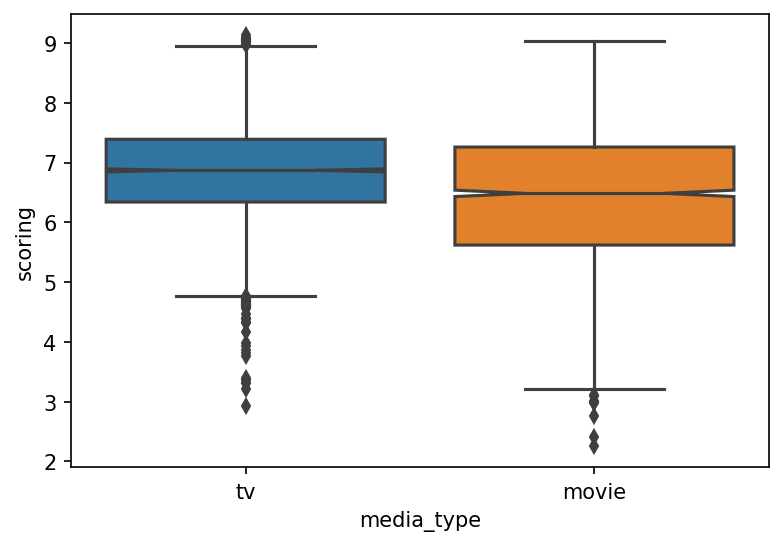

In [3]:
anime_tv_movie = anime.loc[anime.media_type.isin(["tv", "movie"]), :].dropna(subset=["scoring"])
ax = sns.boxplot(x="media_type", y="scoring", data=anime_tv_movie, notch=True)

In [4]:
counts = anime_tv_movie.media_type.value_counts()
counts

tv       4175
movie    2282
Name: media_type, dtype: int64

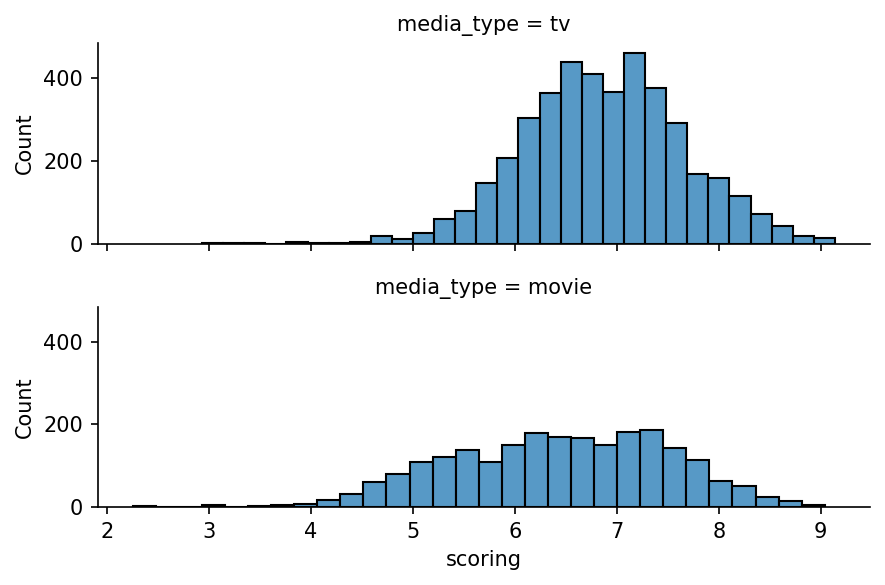

In [5]:
g = sns.FacetGrid(anime_tv_movie, row="media_type", height=2, aspect=3)
g.map(sns.histplot, "scoring", bins=30);

In [6]:
tv_movie_diff_mean_scoring = np.mean(anime_tv_movie.loc[anime_tv_movie.media_type == "tv", "scoring"]) \
    - np.mean(anime_tv_movie.loc[anime_tv_movie.media_type == "movie", "scoring"])

Population parameter

In [7]:
tv_movie_diff_mean_scoring

0.43272950295727686

In [8]:
tv_movie_stdevs = anime_tv_movie.groupby("media_type")["scoring"].apply(np.std)
tv_movie_stdevs

media_type
movie    1.063442
tv       0.795004
Name: scoring, dtype: float64

# Sampling distribution
## Samples of size 200

In [9]:
def create_diff_means_sampling_dist(population, score_column, group_column, group_labels, group_sizes, num_resamples):
    first_population_group = population.loc[
        population[group_column] == group_labels[0], score_column
    ]
    second_population_group = population.loc[
        population[group_column] == group_labels[1], score_column
    ]
    
    samples_sizes_string = f"({group_sizes[0]},{group_sizes[1]})"

    sampling_dist_diffs = []
    for i in range(num_resamples):
        first_group_sample = first_population_group.sample(group_sizes[0], replace=False)
        second_group_sample = second_population_group.sample(group_sizes[1], replace=False)
        
        first_group_sample_mean = first_group_sample.mean()
        second_group_sample_mean = second_group_sample.mean()
        
        this_diff = first_group_sample_mean - second_group_sample_mean
        
        sampling_dist_diffs.append([i + 1, samples_sizes_string, \
            first_group_sample_mean, second_group_sample_mean, this_diff])
    
    return pd.DataFrame(
        data=sampling_dist_diffs, 
        columns=["resample", "sample_sizes", f"{group_labels[0]}_mean_{score_column}", \
            f"{group_labels[1]}_mean_{score_column}", "diff_means"]
    )

In [10]:
sampling_dist_diffs_200 = create_diff_means_sampling_dist(
    population=anime_tv_movie, 
    score_column="scoring", 
    group_column="media_type", 
    group_labels=["tv", "movie"], 
    group_sizes=[200, 200], 
    num_resamples=50000
)

In [11]:
sampling_dist_diffs_200

,resample,sample_sizes,tv_mean_scoring,movie_mean_scoring,diff_means
0,1,"(200,200)",6.80050,6.48760,0.31290
1,2,"(200,200)",6.86625,6.39085,0.47540
2,3,"(200,200)",6.84635,6.35215,0.49420
3,4,"(200,200)",6.81120,6.43010,0.38110
4,5,"(200,200)",6.87645,6.42645,0.45000
...,...,...,...,...,...
49995,49996,"(200,200)",6.78265,6.40200,0.38065
49996,49997,"(200,200)",6.89465,6.44825,0.44640
49997,49998,"(200,200)",6.88750,6.39030,0.49720
49998,49999,"(200,200)",6.83170,6.32240,0.50930


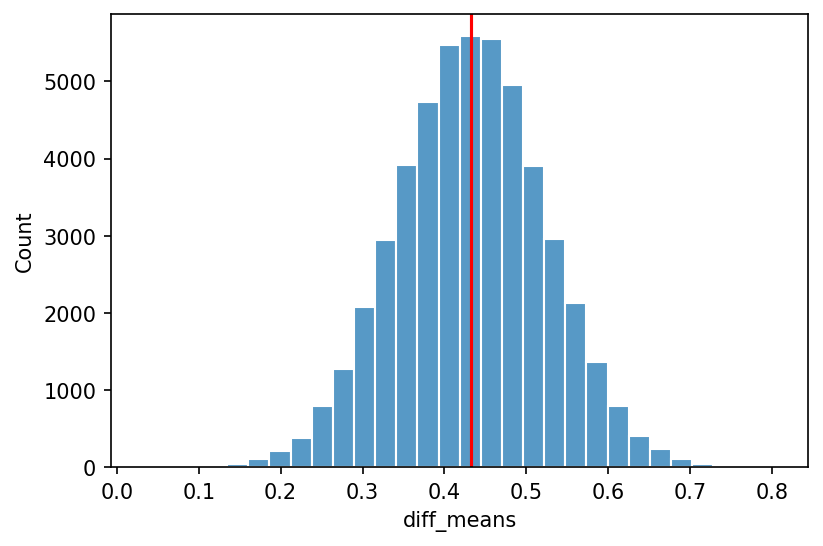

In [12]:
ax = sns.histplot(sampling_dist_diffs_200.diff_means, bins=30, edgecolor="white");
plt.axvline(tv_movie_diff_mean_scoring, 0, 1, color="red");

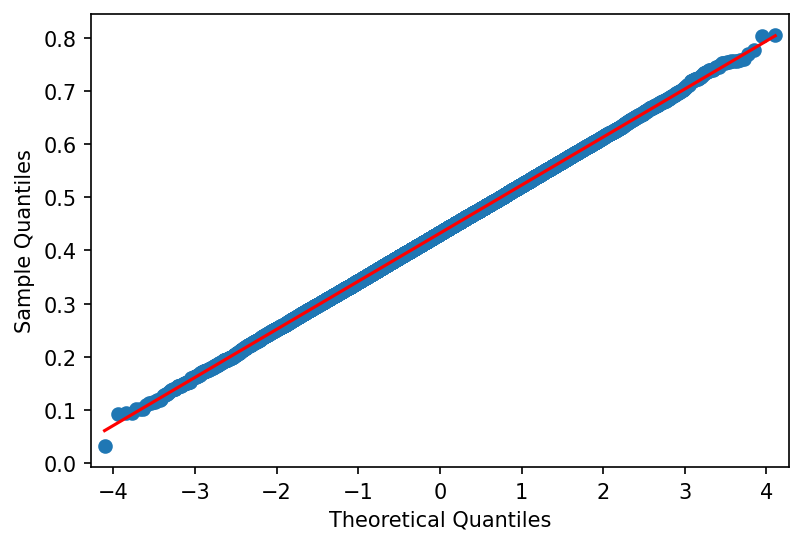

In [13]:
sm.qqplot(sampling_dist_diffs_200.diff_means, line="s");

In [14]:
np.quantile(sampling_dist_diffs_200.diff_means, [0.025, 0.975]) 

array([0.2559475, 0.60935  ])

## Samples of size 1000

In [15]:
sampling_dist_diffs_1000 = create_diff_means_sampling_dist(
    population=anime_tv_movie, 
    score_column="scoring", 
    group_column="media_type", 
    group_labels=["tv", "movie"], 
    group_sizes=[1000, 1000], 
    num_resamples=50000
)

In [16]:
sampling_dist_diffs = pd.concat([sampling_dist_diffs_200, sampling_dist_diffs_1000], axis=0, ignore_index=True)

In [17]:
sampling_dist_diffs

,resample,sample_sizes,tv_mean_scoring,movie_mean_scoring,diff_means
0,1,"(200,200)",6.80050,6.48760,0.31290
1,2,"(200,200)",6.86625,6.39085,0.47540
2,3,"(200,200)",6.84635,6.35215,0.49420
3,4,"(200,200)",6.81120,6.43010,0.38110
4,5,"(200,200)",6.87645,6.42645,0.45000
...,...,...,...,...,...
99995,49996,"(1000,1000)",6.88975,6.42679,0.46296
99996,49997,"(1000,1000)",6.87043,6.44462,0.42581
99997,49998,"(1000,1000)",6.90624,6.45568,0.45056
99998,49999,"(1000,1000)",6.88193,6.42878,0.45315


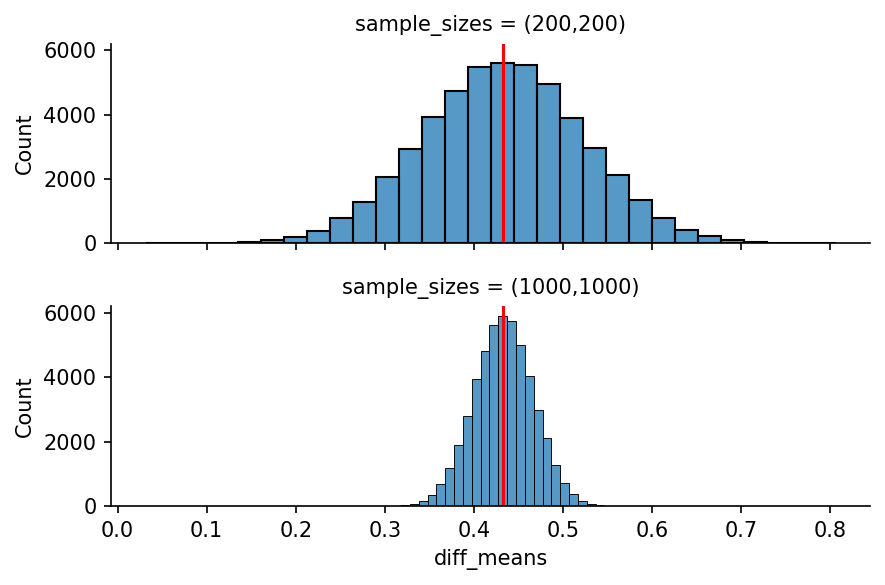

In [18]:
g = sns.FacetGrid(sampling_dist_diffs, row="sample_sizes", height=2, aspect=3)
g.map(sns.histplot, "diff_means", bins=30);
g.map(plt.axvline, x=tv_movie_diff_mean_scoring, ymin=0, ymax=1, color="red");

In [19]:
sampling_dist_diffs \
    .groupby("sample_sizes") \
    .diff_means \
    .agg(
        count=np.size,
        lower_interval=lambda x: np.quantile(x, 0.025),
        upper_interval=lambda x: np.quantile(x, 0.975),
        standard_error=np.std
    )

,count,lower_interval,upper_interval,standard_error
sample_sizes,,,,
"(1000,1000)",50000,0.367249,0.49826,0.033432
"(200,200)",50000,0.255947,0.60935,0.090375


# Central limit theorem

What we've done above is a thought exercise only. In **inferential statistics** we typically:

* don't have access to the whole population. If we did, we calculate the property of interest once, and that's the end of the story (and this would fall in the remit of **descriptive statistics**)
* don't repeatedly sample from the population. Typically, we take one sample, and we make it as large as cost/practicality allow, or as we've determined will provide the *statistical power* necessary to reliably detect the effect we're interested in

$\sigma_{\overline{\textrm{A}}-\overline{\textrm{B}}} = \sqrt{\frac{\sigma_\textrm{A}^2}{n_\textrm{A}} + \frac{\sigma_\textrm{B}^2}{n_\textrm{B}}}$

In [20]:
std_err_200 = np.sqrt(tv_movie_stdevs["tv"]**2/200 + tv_movie_stdevs["movie"]**2/200)
std_err_200

0.09388662752763567

In [21]:
std_err_1000 = np.sqrt(tv_movie_stdevs["tv"]**2/1000 + tv_movie_stdevs["movie"]**2/1000)
std_err_1000

0.04198737626599928

# Reality: a single sample...

Let's have a look at a single sample

In [22]:
def create_single_sample(population, score_column, group_column, group_labels, group_sizes):
    first_population_group = population.loc[
        population[group_column] == group_labels[0], [group_column, score_column]
    ]
    second_population_group = population.loc[
        population[group_column] == group_labels[1], [group_column, score_column]
    ]
    
    first_group_sample = first_population_group.sample(group_sizes[0], replace=False)
    second_group_sample = second_population_group.sample(group_sizes[1], replace=False)
    
    return pd.concat([first_group_sample, second_group_sample], axis=0, ignore_index=True)
    

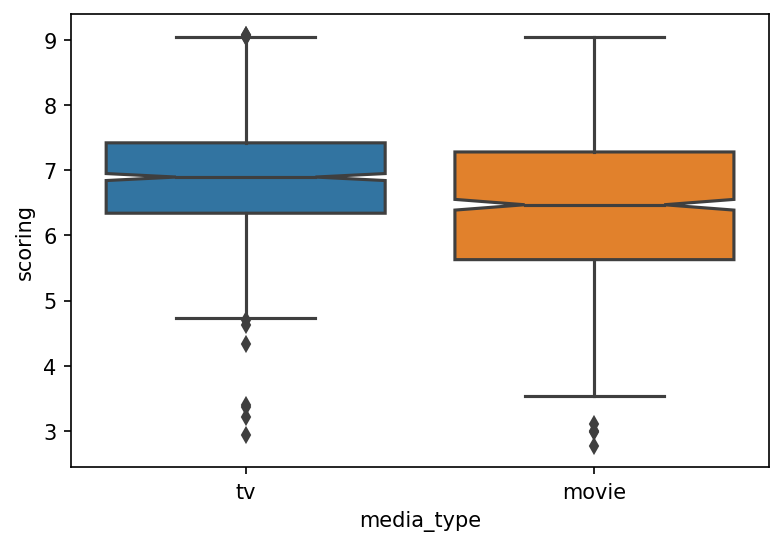

In [23]:
single_sample = create_single_sample(
    population=anime_tv_movie, 
    score_column="scoring", 
    group_column="media_type",
    group_labels=["tv", "movie"], 
    group_sizes=[1000, 1000]
)
ax = sns.boxplot(x="media_type", y="scoring", data=single_sample, notch=True)

In [24]:
single_sample

,media_type,scoring
0,tv,5.63
1,tv,6.14
2,tv,6.59
3,tv,7.89
4,tv,7.00
...,...,...
1995,movie,6.88
1996,movie,7.21
1997,movie,6.78
1998,movie,5.33


In [25]:
sample_statistic = np.mean(single_sample.loc[single_sample.media_type == "tv", "scoring"]) \
    - np.mean(single_sample.loc[single_sample.media_type == "movie", "scoring"])
sample_statistic

0.4517899999999999

So what do we do if we only have this one sample. This is all the data it was practical to gather, and we want to use this to **infer** the 

## Bootstrapping

In [26]:
def create_diff_means_bootstrap_dist(sample, score_column, group_column, group_labels, num_resamples):
    first_sample_group = sample.loc[
        sample[group_column] == group_labels[0], score_column
    ]
    first_sample_group_size = first_sample_group.shape[0]
    second_sample_group = sample.loc[
        sample[group_column] == group_labels[1], score_column
    ]
    second_sample_group_size = second_sample_group.shape[0]
    
    bootstrap_dist_diffs = []
    for i in range(num_resamples):
        first_group_sample = first_sample_group.sample(first_sample_group_size, replace=True)
        second_group_sample = second_sample_group.sample(second_sample_group_size, replace=False)
        
        first_group_sample_mean = first_group_sample.mean()
        second_group_sample_mean = second_group_sample.mean()
        
        this_diff = first_group_sample_mean - second_group_sample_mean
        
        bootstrap_dist_diffs.append([i + 1, \
            first_group_sample_mean, second_group_sample_mean, this_diff])
    
    return pd.DataFrame(
        data=bootstrap_dist_diffs, 
        columns=["resample", f"{group_labels[0]}_mean_{score_column}", \
            f"{group_labels[1]}_mean_{score_column}", "diff_means"]
    )

In [27]:
bootstrap_dist = create_diff_means_bootstrap_dist(
    sample=single_sample,
    score_column="scoring",
    group_column="media_type",
    group_labels=["tv", "movie"],
    num_resamples=50000
)

In [28]:
bootstrap_dist

,resample,tv_mean_scoring,movie_mean_scoring,diff_means
0,1,6.87922,6.44497,0.43425
1,2,6.90188,6.44497,0.45691
2,3,6.97890,6.44497,0.53393
3,4,6.91808,6.44497,0.47311
4,5,6.94373,6.44497,0.49876
...,...,...,...,...
49995,49996,6.93480,6.44497,0.48983
49996,49997,6.95357,6.44497,0.50860
49997,49998,6.96868,6.44497,0.52371
49998,49999,6.88768,6.44497,0.44271


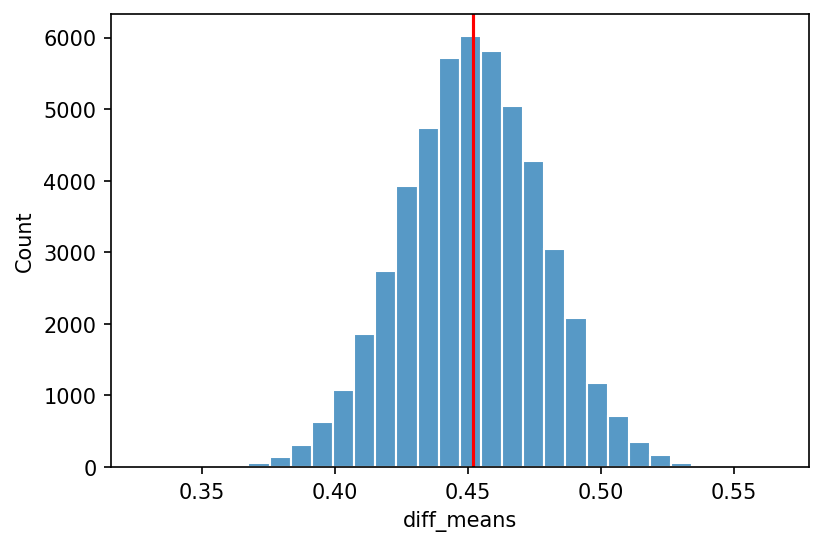

In [29]:
ax = sns.histplot(bootstrap_dist.diff_means, bins=30, edgecolor="white");
plt.axvline(sample_statistic, 0, 1, color="red");

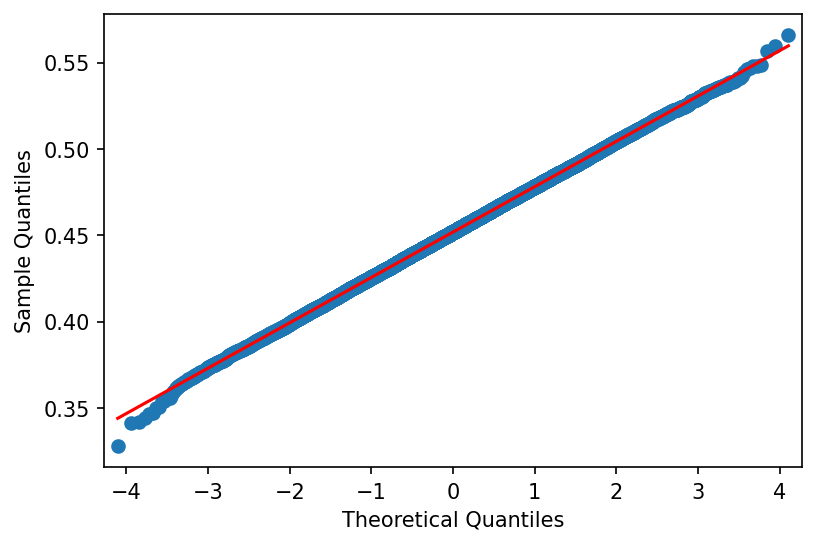

In [46]:
sm.qqplot(bootstrap_dist.diff_means, line="s");

### Percentile bootstrap

In [48]:
def percentile_CI(bootstrap_dist, value_column, confidence_level):
    lower_prob = (1 - confidence_level)/2
    upper_prob = interval_prob + lower_prob
    return np.quantile(bootstrap_dist[value_column], [lower_prob, upper_prob])

In [52]:
percentile_CI(bootstrap_dist, "diff_means", 0.95)

array([0.40009   , 0.50324025])

### Bias-corrected bootstrap

In [64]:
def bias_corrected_CI(bootstrap_dist, sample_stat, value_column, confidence_level):
    '''
    Assumes that bootstrap sampling distribution is normal and should by symmetrically distributed around the 
    sample statistic. Any deviation from latter reflects effects of bias in bootstrap distribution. CI can be 
    corrected to symmetrise distribution around sample statistic. 
    '''
    lower_prob = (1 - confidence_level)/2
    upper_prob = interval_prob + lower_prob
    
    lower_z = norm.ppf(lower_prob)
    upper_z = norm.ppf(upper_prob)
    
    num_below_stat = np.sum(np.array([1 for value in bootstrap_dist[value_column] if value <= sample_stat]))
    frac_below_stat = num_below_stat / bootstrap_dist.shape[0]
    z0 = norm.ppf(frac_below_stat)
    
    corrected_lower_prob = norm.cdf(2 * z0 + lower_z)
    corrected_upper_prob = norm.cdf(2 * z0 + upper_z)
        
    return np.quantile(bootstrap_dist[value_column], [corrected_lower_prob, corrected_upper_prob])

In [67]:
bias_corrected_CI(bootstrap_dist, sample_statistic, "diff_means", 0.95)

array([0.40010708, 0.50324904])

In [62]:
norm.ppf(0.025)

-1.9599639845400545

In [63]:
norm.cdf(-1.9599)

0.0250037398154027